# Lab - Tree Methods

In [ ]:
# Basic packages
import numpy as np
from functools import reduce
from io import BytesIO
import gdown

# Data handling
import pandas as pd
import polars as pl

# Scikit-learn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image
import pydotplus
from tqdm import tqdm
%matplotlib inline

In [ ]:
# Get the data. We'll use Python's interface this time.
gdown.download("https://drive.google.com/uc?id=197ZDgbdQo02kdFwifZJypuBGqsOBrLT1", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=197ZDgbdQo02kdFwifZJypuBGqsOBrLT1
To: /content/placement_data.parquet
100%|██████████| 78.3k/78.3k [00:00<00:00, 12.0MB/s]


'placement_data.parquet'

The data corresponds to an Internship Placement dataset from a US College. It includes information on aptitudes, GPA, other internships, personal projects, etc. The target variable is binary and it shows whether the student was placed or not.

In [ ]:
# Import the data using polars and show its descriptive statistics
placement_df = pl.read_parquet("placement_data.parquet")

# Let's drop the ID column
placement_df = placement_df.drop("StudentID")

# Describe the dataset
placement_df.describe()

statistic,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
str,f64,f64,f64,f64,f64,f64,str,str,f64,f64,str
"""count""",10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,"""10000""","""10000""",10000.0,10000.0,"""10000"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,"""0"""
"""mean""",7.69801,1.0492,2.0266,1.0132,79.4499,4.32396,null,null,69.1594,74.5015,null
"""std""",0.640131,0.665901,0.867968,0.904272,8.159997,0.411622,null,null,10.430459,8.919527,null
"""min""",6.5,0.0,0.0,0.0,60.0,3.0,"""No""","""No""",55.0,57.0,"""NotPlaced"""
"""25%""",7.4,1.0,1.0,0.0,73.0,4.0,null,null,59.0,67.0,null
"""50%""",7.7,1.0,2.0,1.0,80.0,4.4,null,null,70.0,73.0,null
"""75%""",8.2,1.0,3.0,2.0,87.0,4.7,null,null,78.0,83.0,null
"""max""",9.1,2.0,3.0,3.0,90.0,4.8,"""Yes""","""Yes""",90.0,88.0,"""Placed"""


As you can see, the problem has two categorical variables (PlacementTraining, ExtracurricularActivities), the target variable itself is categorical, and the dataset does not seem to have either outliers nor null values.

## Decision Trees

Let's start by training a simple decision tree, and visualizing the outputs. First, let's split train and test data.

In [ ]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(placement_df.drop(pl.col("PlacementStatus")),
                            placement_df.select(pl.col("PlacementStatus")),
                            test_size=0.2,
                            random_state=20250228)

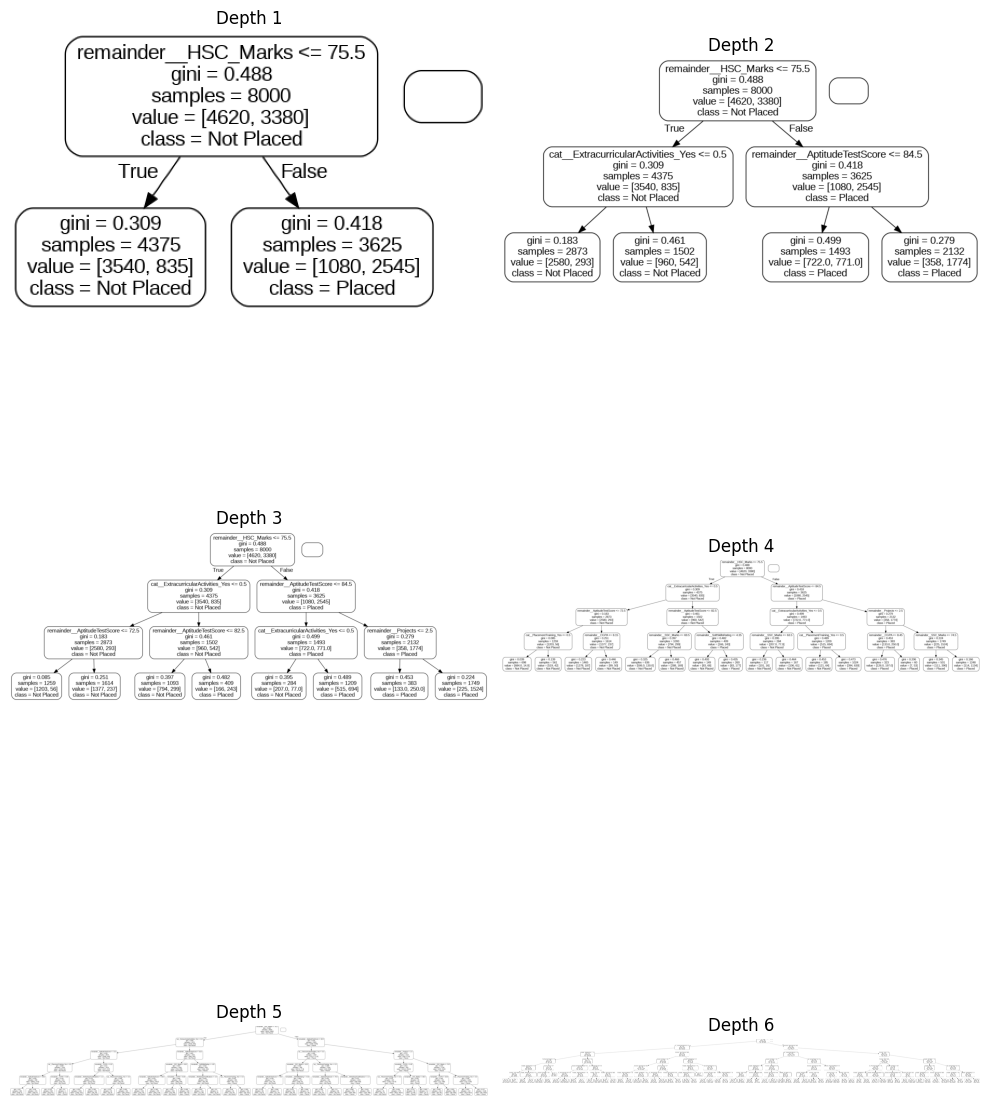

In [ ]:
# Let's train a set of decision trees with variable depths.
depths = np.arange(1,7)

# First, let's define a pipeline.
categorical_features = ["ExtracurricularActivities", "PlacementTraining"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features)],
    remainder='passthrough'
)

# Create a figure for all trees
plt.figure(figsize=(10, 15))

# For each depth, create a tree and display it
for i, d in enumerate(depths):
    reg = DecisionTreeClassifier(max_depth=d)

    # Now we define a Pipeline to process everything
    clf = Pipeline(
        steps=[("preprocessor", preprocessor),
         ("classifier", reg)]
    )

    clf.fit(X_train.to_pandas(), y_train.to_pandas())


    # Create the decision tree visualization
    dot_data = export_graphviz(clf.named_steps["classifier"],
                               out_file=None,
                               rounded=True, max_depth=d,
                               feature_names=clf.named_steps["preprocessor"].get_feature_names_out(),
                               class_names=["Not Placed", "Placed"])
    graph = pydotplus.graph_from_dot_data(dot_data)

    # Create a new subplot for each tree in a 3x2 matrix
    plt.subplot(3, 2, i+1)
    plt.title(f"Depth {d}")

    # Convert the PNG data to an image that matplotlib can display
    png_image = BytesIO(graph.create_png())
    img = plt.imread(png_image)
    plt.imshow(img)
    plt.axis('off')

# Display all trees in one figure
plt.tight_layout()
plt.savefig("decision_trees.pdf")
plt.show()

How did we do? Let's calculate a ROC curve for the last tree.

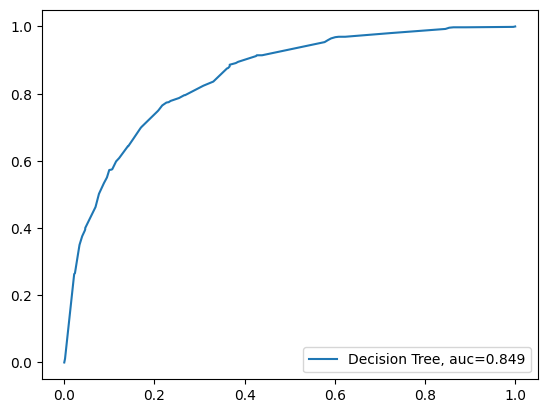

In [ ]:
# Calculate test set values
dt_pred_class_test = clf.predict(X_test.to_pandas())
dt_probs_test = clf.predict_proba(X_test.to_pandas())

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = dt_probs_test[:,1], pos_label="Placed")

# Save the AUC in a variable to display it. Round it first
auc_dt = np.round(roc_auc_score(y_true = y_test, y_score = dt_probs_test[:,1]), decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(auc_dt))
plt.legend(loc=4)
plt.show()

Not bad! What can we do with a more powerful model?

## Random Forests

Now we will train a random forest. It is included in the ```sklearn.ensemble``` subpackage, function [```RandomForestClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), so it is straightforward to use. It comes with many parameters, but in general there is a philosophy to follow:

- In a Random Forest we want each tree to be large, and to learn as much as possible from its subset of data. We don't care too much if each tree is overadjusted, as we can always increase the number of trees to take care of this.

- This said, a good idea is to limit the minimum number of samples per leaf when we have few cases (this is not usually a problem in large trees.)

- We might want to limit the minimum impurity decrease to stop growing a tree if not much is happening.

- There is also a class weight to include. It automatically balances the classes if we use the option ```class_weight=balanced```.

Let's train one and check the options.

In [ ]:
#Define the classifier
placement_rf = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                    criterion='entropy', # How to train the trees: Can be Gini / Entropy / Log-loss
                    max_depth=None, # Max depth of the trees. Not necessary to change.
                    min_samples_split=2, # Minimum samples to create a split.
                    min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                    min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                    max_features='sqrt', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                    max_leaf_nodes=None, # Maximum number of nodes.
                    min_impurity_decrease=0.0001, # Do not add new trees unless the performance imporve by 0.01%
                    bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                    oob_score=True,  # If report accuracy with non-selected cases.
                    n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                    random_state=20190305, # Seed
                    verbose=1, # If to give info during training. Set to 0 for silent training.
                    warm_start=False, # If train over previously trained tree.
                    class_weight='balanced', # Balance classes.
                    )

Let's define the pipeline as before.

In [ ]:
# Feature transformer
categorical_features = ["ExtracurricularActivities", "PlacementTraining"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, categorical_features)], remainder='passthrough')

# Pipeline
placement_rf_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", placement_rf)])

Now we train!

In [ ]:
# Train the RF.
placement_rf_pipe.fit(X_train.to_pandas(), y_train.to_numpy().ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.4s finished
/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ExtracurricularActivities',
                                                   'PlacementTraining'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        min_impurity_decrease=0.0001,
                                        min_samples_leaf=0.001,
                                        n_estimators=1000, n_jobs=-1,
                                        oob_score=True, random_state=20190305,
                                        verbose=1))])

We can see it used two jobs (two processors are available to us in Colab). It converges very quickly. Let's check how it did. Let's calculate the ROC curve.

In [ ]:
# Apply the model to the test set.
rf_pred_class_test = placement_rf_pipe.predict(X_test)
rf_probs_test = placement_rf_pipe.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


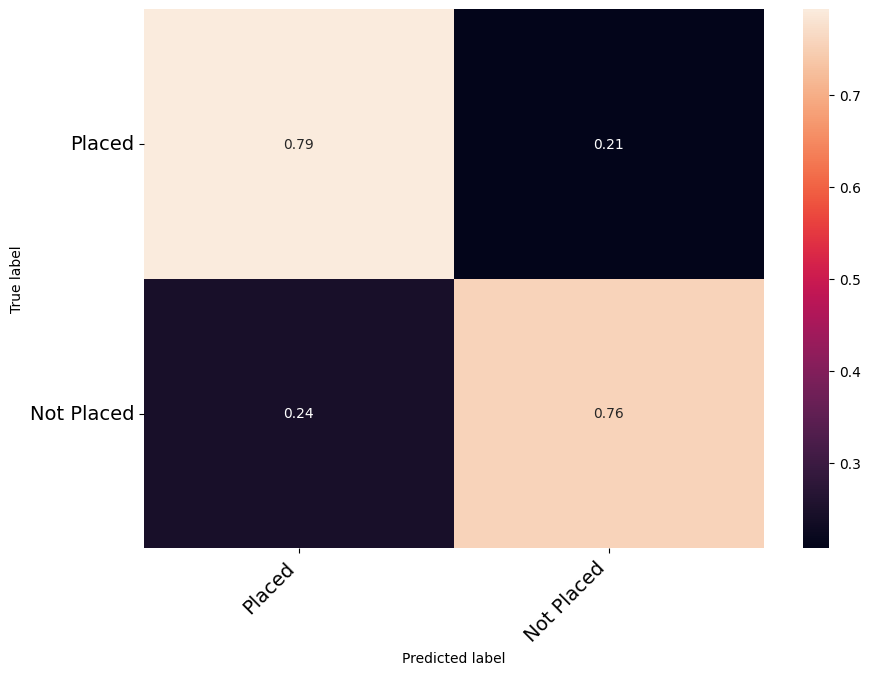

In [ ]:
# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = y_test, y_pred = rf_pred_class_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_rf, index=['Placed', 'Not Placed'], columns=['Placed', 'Not Placed'],)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

In [ ]:
# We can use the out-of-bag score to get an idea of the performance.
placement_rf_pipe.named_steps["classifier"].oob_score_

0.799375

It looks ok! Let's see the ROC curve.

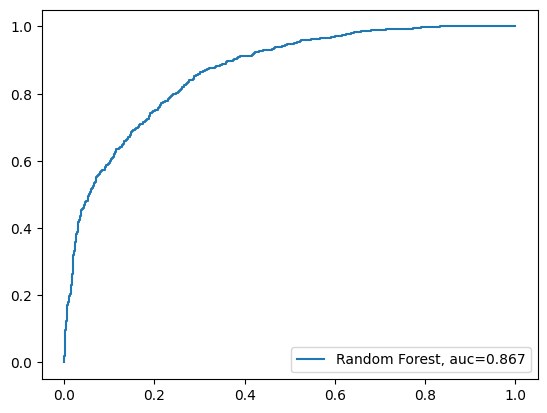

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, rf_probs_test, pos_label="Placed")

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, y_score = rf_probs_test), decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label=f"Random Forest, auc={auc:.3f}")
plt.legend(loc=4)
plt.show()

We were able to gain a few more points already in performance (are they statistically significant?).

Now, let's print the variable importance. The importance is calculated by averaging the accuracy of trees when the variables is included the tree, and comparing it to when it's NOT included the tree.

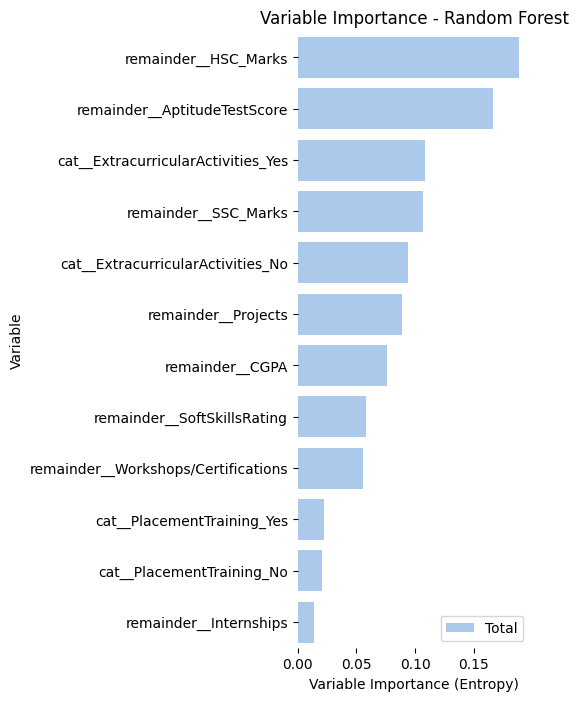

In [ ]:
# Plot variable importance
importances = placement_rf_pipe.named_steps["classifier"].feature_importances_
indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[placement_rf_pipe.named_steps["preprocessor"].get_feature_names_out()[i] for i in indices],
      x=importances[indices],
      label="Total", color="b")

ax.set(ylabel="Variable", xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

# For demo only, do not use this in practice.
# ShapValue is better

As we saw in the lecture, we have a better way to get the variable importance,  using Shap values. Let's use those with an XGBoosting model.

## XGBoosting

The stochastic gradient boosting model is the alternative to Random Forest. Now we want to create a series of small trees, which will be poorer in performance, but together they will be stronger. Training an XGBoost model is harder, because we need to control the model so it creates small trees, but it performs better in small data, something Random Forests do not necessarily accomplish.

While scikit-learn does have its own implementation of XGB ([```sklearn.ensemble```](https://scikit-learn.org/stable/modules/ensemble.html)), there are a couple of very strong packages out there that implement the algorithm. ```xgboost``` and ```lightgbm``` are two of the best known ones. We will use [```xgboost```](https://xgboost.readthedocs.io/en/latest/python/) for this lab, available pretty much for every language out there.

The first step is to define a classifier that we will use.

In [ ]:
# Calculate the positive weight
# If there are more 0 than 1, which is nomarly the case, the positive rate > 1
positive_weight = y_train.to_pandas().value_counts().iloc[0] / y_train.to_pandas().value_counts().iloc[1]
print(f"The balanced weight for the loss function is {positive_weight:.3f}")

# Define the classifier
XGB_Placement = XGBClassifier(max_depth=3, # Depth of each tree
                learning_rate=0.1, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                n_estimators=100, # How many trees to use, the more the better, but decrease learning rate if many used.
                verbosity=1, # If to show more errors or not.
                objective='binary:logistic', # Type of target variable.
                booster='gbtree', # What to boost. Trees in this case.
                n_jobs=-1, # Parallel jobs to run. Set your processor number.
                gamma=0.001, # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                subsample=0.632, # Subsample ratio. Can set lower
                colsample_bytree=1, # Subsample ratio of columns when constructing each tree.
                colsample_bylevel=1, # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                colsample_bynode=1, # Subsample ratio of columns when constructing each split.
                scale_pos_weight=positive_weight, # Balancing of positive and negative weights.
                base_score=0.5, # Global bias. Set to average of the target rate.
                random_state=20201107 # Seed
                )

The balanced weight for the loss function is 1.367


This classifier can be used to tune the parameters of the model. We will use sklearn's ```GridSearchCV``` for this. It requires a dictionary of the parameters to look for. We will tune the number of trees (XGB overfits relatively easily, always tune this), the depth, and the learning rate.

In [ ]:
# Define the parameters. Play with this grid!
param_grid = dict({'n_estimators': [50, 100, 150],
          'max_depth': [2, 3],
          'learning_rate' : [0.001, 0.01, 0.1]
          })
param_grid

{'n_estimators': [50, 100, 150],
 'max_depth': [2, 3],
 'learning_rate': [0.001, 0.01, 0.1]}

We will create a validation set for the sample.

In [ ]:
# If the dataset is too big, you can always create a validation set over which to do the parameter search.
val_sample = X_train.with_columns(pl.Series("PlacementStatus", y_train.to_numpy().ravel()))
# If we cannot train all the samples:
# val_sample = X_train.with_columns(pl.Series("PlacementStatus", y_train.to_numpy().ravel())).sample(fraction=0.6)
val_sample.describe()

statistic,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
str,f64,f64,f64,f64,f64,f64,str,str,f64,f64,str
"""count""",8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,"""8000""","""8000""",8000.0,8000.0,"""8000"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,"""0"""
"""mean""",7.69735,1.052125,2.029375,1.0125,79.479125,4.324712,null,null,69.226125,74.524,null
"""std""",0.640372,0.665367,0.868105,0.907577,8.192738,0.412182,null,null,10.397512,8.915695,null
"""min""",6.5,0.0,0.0,0.0,60.0,3.0,"""No""","""No""",55.0,57.0,"""NotPlaced"""
"""25%""",7.4,1.0,1.0,0.0,73.0,4.0,null,null,59.0,67.0,null
"""50%""",7.7,1.0,2.0,1.0,80.0,4.4,null,null,71.0,73.0,null
"""75%""",8.2,1.0,3.0,2.0,87.0,4.7,null,null,78.0,83.0,null
"""max""",9.1,2.0,3.0,3.0,90.0,4.8,"""Yes""","""Yes""",90.0,88.0,"""Placed"""


Now we can do a grid search over the parameter space. We will use the AUC (as this is a binary classification problem

In [ ]:
# Define the cross-validation object. We'll use 3-fold cross-validation.
cv_object = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 20250304)

# Define a column transformer for the categorical variables and the label encoder.
categorical_features = ["ExtracurricularActivities", "PlacementTraining"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, categorical_features)],remainder='passthrough')

# Apply a LabelEncoder to the target variable.
label_encoder = LabelEncoder()
val_sample = val_sample.with_columns([pl.col("PlacementStatus").map_batches(label_encoder.fit_transform)])

# Pipeline
placement_rf_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", placement_rf)])

# Define grid search object.
GridXGB = GridSearchCV(XGB_Placement,        # Original XGB.
            param_grid,          # Parameter grid
            cv = cv_object,       # Cross-validation object.
            scoring = 'roc_auc',    # How to rank outputs.
            n_jobs = -1,        # Parallel jobs. -1 is "all you have"
            refit = False,       # If refit at the end with the best. We'll do it manually.
            verbose = 1         # If to show what it is doing.
            )

# Define a pipeline with the preprocessor and the classifier
XGB_pipe = Pipeline(steps=[("preprocessor", preprocessor),("classifier", GridXGB)])

In [ ]:
# Let's check the sample to see if it's correct.
val_sample.describe()

statistic,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
str,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64
"""count""",8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,"""8000""","""8000""",8000.0,8000.0,8000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0
"""mean""",7.69735,1.052125,2.029375,1.0125,79.479125,4.324712,null,null,69.226125,74.524,0.4225
"""std""",0.640372,0.665367,0.868105,0.907577,8.192738,0.412182,null,null,10.397512,8.915695,0.493988
"""min""",6.5,0.0,0.0,0.0,60.0,3.0,"""No""","""No""",55.0,57.0,0.0
"""25%""",7.4,1.0,1.0,0.0,73.0,4.0,null,null,59.0,67.0,0.0
"""50%""",7.7,1.0,2.0,1.0,80.0,4.4,null,null,71.0,73.0,0.0
"""75%""",8.2,1.0,3.0,2.0,87.0,4.7,null,null,78.0,83.0,1.0
"""max""",9.1,2.0,3.0,3.0,90.0,4.8,"""Yes""","""Yes""",90.0,88.0,1.0


In [ ]:
# Label enconder to transform target to numerical

# Train grid search.
XGB_pipe.fit(val_sample.drop("PlacementStatus").to_pandas(), val_sample.select("PlacementStatus").to_numpy().ravel())

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ExtracurricularActivities',
                                                   'PlacementTraining'])])),
                ('classifier',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=20250304, shuffle=True),
                              estimator=XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      callbacks=Non...
                                                      max_delta_step=None,
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      random_state=20201107, ...),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.001, 0.01, 0.1],
                                          'max_depth': [2, 3],
                                          'n_estimators': [50, 100, 150]},
                              refit=False, scoring='roc_auc', verbose=1))])

Now we can output the optimal parameters.

In [ ]:
# Show best params
XGB_pipe.named_steps["classifier"].best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

It is telling us to use 10% learning rate with a max_depth of 2 and 50 trees. If any parameter were to be at the limit, you would need to run it again with a higher limit.

We can get the details of the runs accessing cv_results_

In [ ]:
XGB_pipe.named_steps["classifier"].cv_results_

{'mean_fit_time': array([0.18619251, 0.26332506, 0.26025526, 0.17358907, 0.19447947,
        0.56399131, 0.23360117, 0.32032593, 0.38240004, 0.12932038,
        0.22499855, 0.3356599 , 0.08698869, 0.27341501, 0.47793881,
        0.18079034, 0.17830396, 0.2579929 ]),
 'std_fit_time': array([0.08001462, 0.0723954 , 0.01726832, 0.00747251, 0.01541093,
        0.11109036, 0.02976146, 0.03739805, 0.03406915, 0.05092299,
        0.01595132, 0.07467676, 0.02181476, 0.06051276, 0.01650861,
        0.02306757, 0.05900232, 0.07438378]),
 'mean_score_time': array([0.01478426, 0.01833502, 0.02291918, 0.02964369, 0.0235912 ,
        0.06146105, 0.04432336, 0.03533554, 0.02592333, 0.01792034,
        0.02117078, 0.03336032, 0.02182674, 0.04439775, 0.03627698,
        0.02727063, 0.02141094, 0.02166224]),
 'std_score_time': array([0.0059352 , 0.00598066, 0.01188509, 0.00809729, 0.00903263,
        0.00978239, 0.00434861, 0.01408804, 0.00974196, 0.00779131,
        0.00724974, 0.01498292, 0.01209526, 

Now we can fit the final model!

In [ ]:
# Create XGB with best parameters.
XGB_Placement = XGBClassifier(max_depth=XGB_pipe.named_steps["classifier"].best_params_.get('max_depth'), # Depth of each tree
                learning_rate=XGB_pipe.named_steps["classifier"].best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                n_estimators=XGB_pipe.named_steps["classifier"].best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                verbosity=1,                  # If to show more errors or not.
                objective='binary:logistic',  # Type of target variable.
                booster='gbtree',             # What to boost. Trees in this case.
                n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                subsample=0.632,                  # Subsample ratio. Can set lower
                colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                reg_lambda=0,                 # Regularizer for first fit.
                scale_pos_weight=1,           # Balancing of positive and negative weights.
                base_score=0.5,               # Global bias. Set to average of the target rate.
                random_state=20201107,        # Seed
                )

# Define a pipeline with the preprocessor and the classifier
XGB_pipe = Pipeline(steps=[("preprocessor", preprocessor),("classifier", XGB_Placement)])

In [ ]:
# Train over all training data.
y_train = label_encoder.fit_transform(y_train.to_numpy().ravel())

# Train the pipeline
XGB_pipe.fit(X_train.to_pandas(), y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ExtracurricularActivities',
                                                   'PlacementTraining'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, device=None,
                               early_stopping_ro...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=4,
                               num_parallel_tree=None, random_state=20201107, ...))])

Let's finish by plotting the ROC curves for all models.

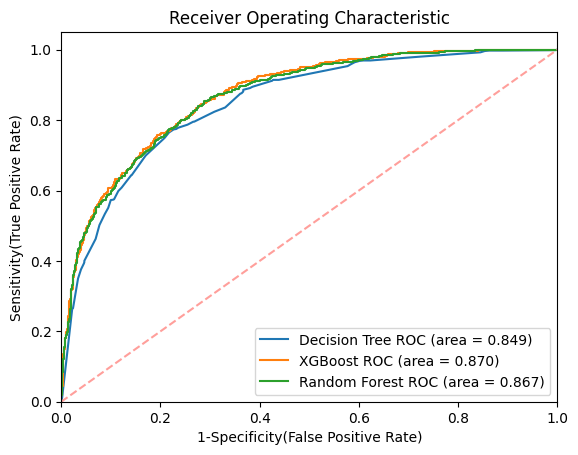

In [ ]:
# Calculate probability
y_test = label_encoder.fit_transform(y_test)
xgb_prob_test = XGB_pipe.predict_proba(X_test.to_pandas())
xgb_prob_test = xgb_prob_test[:, 1]

# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'Decision Tree',
    'probs': dt_probs_test[:, 1]
},
{
    'label': 'XGBoost',
    'probs': xgb_prob_test
},
{
    'label': 'Random Forest',
    'probs': rf_probs_test
}
]

# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
  auc = roc_auc_score(y_true = y_test,y_score = m['probs'])
  fpr, tpr, thresholds = roc_curve(y_test, m['probs'])
  plt.plot(fpr, tpr, label=f'{m["label"]} ROC (area = {auc:.3f})')

# Settings
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot!
plt.show()

How do the different models compare? Why do you think this is?

## TreeSHAP

The variable importance plots are quite useful to get a first look at the impact of each variable in the model. However, there is a much better way of doing this using the well-known Shapley Values. The method, adapted to tree models, is called [SHAP](https://github.com/slundberg/shap). It works by using a game-theoretical approach to comparing when the variable is in a model versus when it is not. The technical details are published in [this paper](https://www.nature.com/articles/s42256-019-0138-9).

The method requires an already trained XGB model. The package is fairly comprehensive, but we will focus on these two elements:

1. How to measure the average impact of each variables on a sample of cases (the most important application!).

2. How to measure the impact of each variable on prediction.

Reading the documentation will allow you to make other plots.

In [ ]:
# Create transformed data from previous preprocessor. It unfortunately does not support polars.
data = pd.DataFrame(preprocessor.fit_transform(X_test.to_pandas()))
data.columns = preprocessor.get_feature_names_out()

# Trains the game-theoretic model. Really complex so requires sampling.
explainer = shap.TreeExplainer(XGB_pipe.named_steps["classifier"], # The model
                data = shap.sample(data, 1000)  # Create a sample of 1000 cases
                )

# Applies model ot the full dataset.
shap_values = explainer.shap_values(data, check_additivity=False)

Now we can run the first plot. We will calculate the contribution to explanations for all points in the sample.

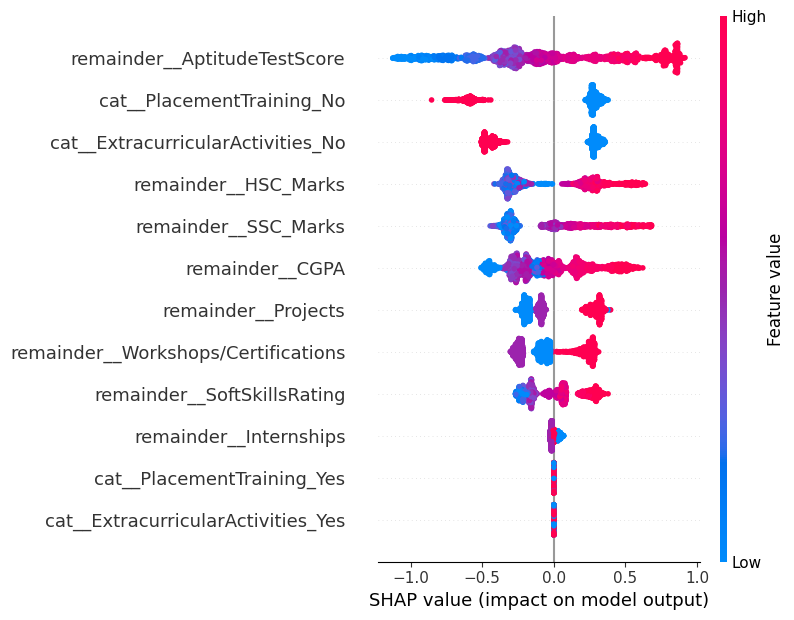

In [ ]:
shap.summary_plot(shap_values, # The Shapley values.
        data,     # The training sample
        show=False   # Whether to print the model or not
        )

# Let's save this as a PDF for later use.
plt.savefig('ShapSummaryPlot.pdf', dpi=300, bbox_inches='tight')
plt.show()

How to read this plot?

1. The absolute value of the Shapley value (x-axis) is how important the variable is for predicting, while the sign says whether the prediction is towards a positive value (Placed in this case) or a zero value (Not Placed).

2. The colour in the plot says whether the feature value is high or low for that Shapley score.

3. The y-axis shows all variables ordered from more useful to less useful in predicting.

**So, for example, let's consider AptitudeTestScore. This variable represents the student's aptitude score. We can see that high values are related to very high Shapley values, meaning that high values are very helpful (in fact, the most helpful of all sets of values in the dataset) to predict the probability of a student securing a placement, while low values are helpful to predict the opposite, but not as much. Here the non-linear behaviour of the variable is shown quite clearly!**

Now, let's dig in the impact of each variable.

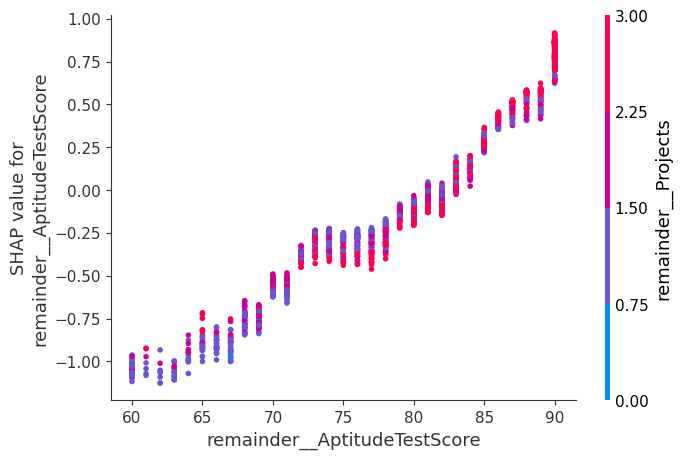

In [ ]:
shap.dependence_plot("remainder__AptitudeTestScore",  # The variable to study
          shap_values,            # The Shapley values.
          data,               # The training sample
          show=False)            # Whether to print the model or not

plt.savefig('ShapEmploy.pdf', dpi=300, bbox_inches='tight')
plt.show()

# How different score of the test affect the prediction

This plot shows the value of the variable in the X-axis and compares it with the value of the Shap coefficient in the Y-axis. The colour now represents the value of the most correlated variable in the dataset (in this case, the binary variable marking for the candidate NOT having extracurricular activities) and it is given for reference only.

In this plot, we can see how low aptitude tests strongly correlate with lower chances of securing an internship, and how most of these students do not have extracurriculars either.

Now you can study variables in detail and make fairly detailed explanations!

The last step is to analyse one single case. We can use a [force plot](https://shap.readthedocs.io/en/latest/generated/shap.plots.force.html) for that purpose.

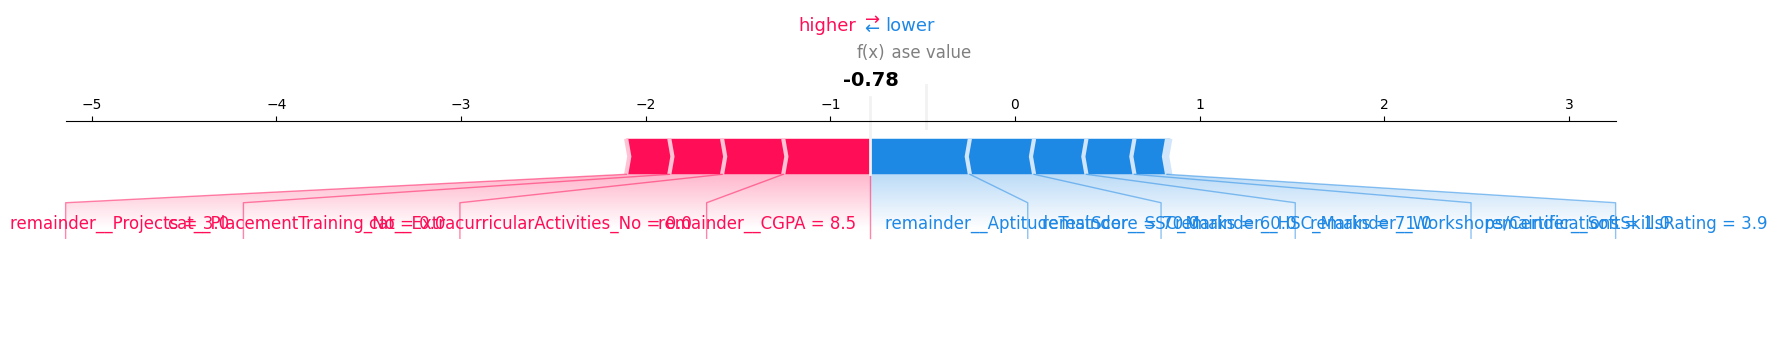

In [ ]:
# Show the force plot for the first element in the dataset.
shap.plots.force(explainer.expected_value, shap_values[0], data.iloc[0,:], show=False, matplotlib=True)
plt.savefig('ShapForcePlot.pdf', dpi=300, bbox_inches='tight')
plt.show()

We can see that, overall, the Shap value of the student is -0.78, meaning they are more likely to not get an internship than to get it. This is mostly due to a GPA of 8.5. On the positive side, their Aptitude Score and their SSC Marks contribute, but not enough to counterbalance the other elements.

Now you can also provide individual responses to each customer, satisfying modern legal requirements of explainability!